In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bax-for-xgb-with-tuning/df_bax_cleaned_to_view_outliers.csv


Training data shape: (2919, 5), (2919,)
Testing data shape: (730, 5), (730,)

Starting Grid Search for hyperparameter tuning...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Grid Search complete.

Best Parameters found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Best RMSE from Grid Search: 52.31

Training final XGBoost model with best parameters...
Training complete.

Final Mean Absolute Error (MAE): 28.75
Final Root Mean Squared Error (RMSE): 36.64


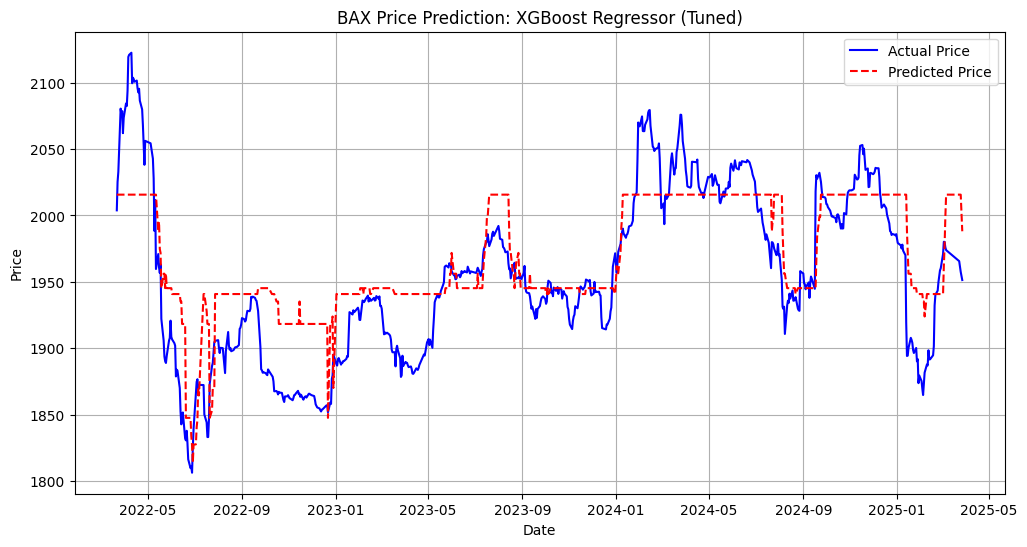

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset
try:
    df = pd.read_csv('/kaggle/input/bax-for-xgb-with-tuning/df_bax_cleaned_to_view_outliers.csv')
except FileNotFoundError:
    print("Error: The file 'df_bax_cleaned_to_view_outliers.csv' was not found.")
    exit()

# --- 1. Data Preprocessing and Feature Engineering ---
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df[['Price']].copy()

# Create lagged features
lags = [1, 2, 3, 5, 10]
for lag in lags:
    data[f'Price_lag_{lag}'] = data['Price'].shift(lag)

data.dropna(inplace=True)

X = data.drop('Price', axis=1)
y = data['Price']

# --- 2. Data Splitting ---
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

# --- 3. Hyperparameter Tuning with Grid Search ---
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.05]
}

# Initialize the XGBoost Regressor
xg_model_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xg_model_base,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

print("\nStarting Grid Search for hyperparameter tuning...")
grid_search.fit(X_train, y_train)
print("Grid Search complete.")

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert to positive RMSE
print(f"\nBest Parameters found: {best_params}")
print(f"Best RMSE from Grid Search: {best_score:.2f}")

# --- 4. Model Training with Best Parameters ---
# Train a new model using the best parameters found by Grid Search
final_xg_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42, n_jobs=-1)
print("\nTraining final XGBoost model with best parameters...")
final_xg_model.fit(X_train, y_train)
print("Training complete.")

# --- 5. Making Predictions ---
predictions = final_xg_model.predict(X_test)

# --- 6. Model Evaluation ---
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"\nFinal Mean Absolute Error (MAE): {mae:.2f}")
print(f"Final Root Mean Squared Error (RMSE): {rmse:.2f}")

# --- 7. Visualization ---
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Price', color='blue')
plt.plot(y_test.index, predictions, label='Predicted Price', color='red', linestyle='--')
plt.title('BAX Price Prediction: XGBoost Regressor (Tuned)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()